In [2]:
##Code Section for Declaring Imports##

from bs4 import BeautifulSoup # Load the libraries for beautiful soup
import requests
#import urllib2
import time 
import pandas as pd
import pickle

from collections import defaultdict
import pageviewapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats


from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
#Setting Options
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 100)

In [ ]:
def format_float(value):
    return f'{value:,.2f}'

pd.options.display.float_format = format_float

# 1. Code Section for Beautiful Soup Headers

In [ ]:
##Code Section for Beautiful Soup Headers##

headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

page = "https://fbref.com/en/comps/9/1526/2016-2017-Premier-League-Stats"
pageTree = requests.get(page, headers=headers)
pageSoup_teams = BeautifulSoup(pageTree.content, 'html.parser')

# 2. Code Section to fetch the Teams - Source : Fbref.com

In [ ]:
##Code Section to fetch the Teams ##

Player_Teams = []
Player_Teams_upd_mod = []
Player_Teams_upd = []
table = pageSoup_teams.find('table', class_ = 'min_width sortable stats_table')
for link in table.find_all('a'):
        temp = "https://fbref.com" + link.get("href") 
        #temp_17 = "https://fbref.com" + link.get("href") 
        team_name = link.text
        Player_Teams.append([team_name,temp])
        #Player_Teams.append([team_name,temp_16])

#Player_Teams_upd_2016 = []
#Player_Teams_upd_2017 = []

for value in Player_Teams:
    if value[1][-1:-6:-1] == 'statS':
        Player_Teams_upd.append(value)

[Player_Teams_upd_mod.append(x) for x in Player_Teams_upd if x not in Player_Teams_upd_mod];        

#for value in Player_Teams_2017:
#    if value[1][-1:-6:-1] == 'statS':
#        Player_Teams_upd_2017.append(value)

        
#Player_Teams_upd;        

In [ ]:
Player_Teams_upd_mod;

### 2.1 Code Section to fetch the Players from Teams - Source : Fbref.com

In [ ]:
##Code Section to fetch Player List from Teams ##

Players_Info = {}
for player_page in Player_Teams_upd:
    page = player_page[1]
    player_team = player_page[0]
    pageTree = requests.get(page, headers=headers)
    pageSoup_teams = BeautifulSoup(pageTree.content, 'html.parser')
    
    for table in pageSoup_teams.find_all('div', id = 'div_stats_standard_1526'):
        rows = [row for row in table.find_all('tr')]
    for index in range(2,len(rows)-2):
        player_name =     rows[index].find_all('th')[0].find('a').text
        player_url  =     'https://fbref.com' + rows[index].find_all('th')[0].find('a')['href']
        player_details =  rows[index].find_all('td')
        Players_Info[player_name] = [player_name] + [player_url] + [player_team] + [i.text for i in player_details[:-1]] 

Players_Info_df = pd.DataFrame(Players_Info).T  #transpose
Players_Info_df.columns = ['Player','PlLink','Team','Nation', 'Pos','Age','MP','Starts','Min','90s','Gls','Ast', 
                    'PK','PKatt','CrdY','CrdR','PGls','PAst','PG+A','PG-PK','PG+A-PK'] 
Players_Info_df.set_index('Player', inplace= True)
Players_Info_df;        

In [ ]:
Players_Info_df;

### 2.2 Code Section to fetch Player level Attributes - Source : Fbref.com

In [ ]:
##Code Section to fetch Specific Player Attributes##
Player_Attr = {}
Player_Shooting = {}
for index, row in enumerate(Players_Info_df.itertuples()):
    page = row.PlLink
    pageTree = requests.get(page, headers=headers)
    pageSoup_player = BeautifulSoup(pageTree.content, 'html.parser')

    #pageSoup_player 
    for table in pageSoup_player.find_all('div', class_ = 'players', id = 'info'):
        #print(table)
        rows = [row for row in table.find_all('p')]
        headings = [heading for heading in table.find_all('h1') ]
    try:   
        #print(headings[0])
        player_name   = headings[0].find('span').text
        #print(player_name)
        player_height = rows[2].find_all('span')[0].text
        player_weight = rows[2].find_all('span')[1].text
        player_footedness = rows[1].text
        Player_Attr[player_name] = [player_name] + [player_height] + [player_weight] + [player_footedness]
    except:
        player_name   = 'Error'
        player_height = 'Error'
        player_weight = 'Error'
        player_footedness = 'Error'
        Player_Attr[player_name] = [player_name] + [player_height] + [player_weight] + [player_footedness]
        continue
#    for table in pageSoup_player.find_all('div', id = 'div_stats_shooting_dom_lg'):
#        rows = [row for row in table.find_all('tr')]
        #for index in range(4:18): 
#        items = rows[12].find_all('td')
#        Player_Shooting[player_name] = [player_name] + [i.text for i in items[4:]]

#print(Player_Shooting)
#Players_Shooting_df = pd.DataFrame(Player_Shooting).T 
#Players_Shooting_df.columns = ['Player','','Weight','Footedness']#print(rows[3])

Players_Attr_df = pd.DataFrame(Player_Attr).T  #transpose
Players_Attr_df.columns = ['Player','Height','Weight','Footedness'] 
Players_Attr_df.set_index('Player', inplace= True)
## Merge the above different Player specific information into a single DataFrame for players
Players_Info_outer_merged = Players_Info_df.merge(Players_Attr_df, how='inner', left_on='Player', right_on='Player')
#Players_Info_outer_merged = pd.merge(Players_Info_df, Players_Attr_df,
#                        how="outer", on=["Player"])

In [ ]:
Players_Info_outer_merged;

# 3. Code Section to fetch markvet value of the Players - Source : Transfermarkt.com

### 3.1 Beautiful Soup Header for Transfermark.com website(for market valuations)

In [ ]:
##Code Section to fetch Player Market Valuations from TransferMarket Website##
page = "https://www.transfermarkt.us/premier-league/daten/wettbewerb/GB1"
pageTree = requests.get(page, headers=headers)
pageSoup_teams = BeautifulSoup(pageTree.content, 'html.parser')


### 3.2 Fetch the teams

In [ ]:
Teams = []
Teams_mod = []
for table in pageSoup_teams.find_all('table', class_='items'):
    #time.sleep(20)
    for link in table.find_all('a'):
        temp = "https://www.transfermarkt.us" + link.get("href") 
        Teams.append(temp)
  ## Notice that there are redundant links in the list so I am filtering out the duplicate values      
    [Teams_mod.append(x) for x in Teams if x not in Teams_mod]

Teams_corr = Teams_mod[4::2] #This is to clean-up redundant and un-necessary links in the data     
Teams_corr;

In [ ]:
Teams_corr[0:5]

In [ ]:
team_page_temp = []
team_page_temp = Teams_corr[0:5]
print(team_page_temp)

In [ ]:
Teams_corr

### 3.3 Fetch players from each of the teams

In [ ]:
Teams_Players_Names = []
Teams_Players_Valuations_2016 = []
Teams_Players_Valuations_2017 = []
Teams_Players_Names_2017 = []
Teams_Players_Positions = []
Teams_Players = []
Teams_Players_mod = []
team_page_temp = []
Player_2016 = {}
Player_2017 = []
#team_page_temp = Teams_corr[0:11]
player_valuations_dataframe = pd.DataFrame()
#for team_pa'https://www.transfermarkt.us/chelsea-fc/startseite/verein/631?saison_id=20ge in Teams_corr: ## For each team in the list -> we go ahead to fetch the players
test_page = "https://www.transfermarkt.us/fc-everton/startseite/verein/29"
#team_page_temp.append(Teams_corr[0:1])
#team_page_temp.append(test_page)
for team_page in Teams_corr: ## We Look through the list and fetch every team and load their respective pages 
    
    #time.sleep(20)
    #print(team_page)
    #a_dict = collections.defaultdict(list)
    #a_dict["a"].append("hello")
    #print(a_dict)
    #OUTPUT
    #defaultdict(<class 'list'>, {'a': ['hello']})
    #a_dict["a"].append("kite")
    #print(a_dict)

    team_page_2016 = team_page +  "?saison_id=2016"
    pageTree = requests.get(team_page_2016, headers=headers)
    pageSoup_player = BeautifulSoup(pageTree.content, 'html.parser')
    for table in pageSoup_player.find_all('table', class_='items'):
        #for link in table.find_all('td'):
        for player_link in table.find_all('a',class_ = 'spielprofil_tooltip'):
                player_name = player_link.get("title")
                if player_name not in Teams_Players_Names:
                    Teams_Players_Names.append(player_name)
                #print(player_name)
        for player_value_link in table.find_all('td',class_= 'rechts hauptlink'):
                #player_valuation = player_value_link.text
                #if player_valuation == '&nbsp':
                #    print('&nbsp')
                player_valuation = player_value_link.text.split('\xa0')[0]
                if not player_valuation :
                    player_valuation = '0'
                Teams_Players_Valuations_2016.append(player_valuation)
                #player_valuation = player_value_link.text
                #player_valuation = player_valuation.split("\")[0]
                #print(player_valuation)                                                
                #if not player_valuation:
                #    player_valuation = 'N/A'
                #Teams_Players_Valuations_2016.append(player_valuation)
        
                #print(player_valuation)
            #if player_name not in Player_2016:
    Teams_Players_Valuations_2016 = Teams_Players_Valuations_2016[0:776]
    Player_2016 = {'Player': Teams_Players_Names, 'Valuation-2016':Teams_Players_Valuations_2016 }    
    
    team_page_2017 = team_page +  "?saison_id=2017"
    pageTree = requests.get(team_page_2017, headers=headers)
    pageSoup_player = BeautifulSoup(pageTree.content, 'html.parser')
    for table in pageSoup_player.find_all('table', class_='items'):
        #for link in table.find_all('td'):
        for player_link in table.find_all('a',class_ = 'spielprofil_tooltip'):
                player_name = player_link.get("title")
                if player_name not in Teams_Players_Names_2017:
                    Teams_Players_Names_2017.append(player_name)
                #print(player_name)
        for player_value_link in table.find_all('td',class_= 'rechts hauptlink'):
                #player_valuation = player_value_link.text
                #if player_valuation == '&nbsp':
                #    print('&nbsp')
                player_valuation = player_value_link.text.split('\xa0')[0]
                if not player_valuation :
                    player_valuation = '0'
                Teams_Players_Valuations_2017.append(player_valuation)
                #player_valuation = player_value_link.text
                #player_valuation = player_valuation.split("\")[0]
                #print(player_valuation)                                                
                #if not player_valuation:
                #    player_valuation = 'N/A'
                #Teams_Players_Valuations_2016.append(player_valuation)
        
                #print(player_valuation)
            #if player_name not in Player_2016:
            
    Teams_Players_Valuations_2016 = Teams_Players_Valuations_2016[0:776]
    Player_2016 = {'Player': Teams_Players_Names, 'Valuation-2016':Teams_Players_Valuations_2016 }    
    Teams_Players_Valuations_2017 = Teams_Players_Valuations_2017[0:732]
    Player_2017 = {'Player': Teams_Players_Names_2017, 'Valuation-2017':Teams_Players_Valuations_2017 }    
    
    
    #team_page_2017 = team_page +  "?saison_id=2017"
    #pageTree = requests.get(team_page_2017, headers=headers)
    #pageSoup_player = BeautifulSoup(pageTree.content, 'html.parser')
    #for table in pageSoup_player.find_all('table', class_='items'):
        #rows = [row for row in table.find_all('a',class_ = 'spielprofil_tooltip')]
        #headings = [heading for heading in table.find_all('h1') ]
    #try:   
        #print(headings[0])
    #    player_name   = headings[0].find('span').text
        #print(player_name)
    #    player_height = rows[2].find_all('span')[0].text
    #    player_weight = rows[2].find_all('span')[1].text
    #    player_footedness = rows[1].text
    #    Player_Attr[player_name] = [player_name] + [player_height] + [player_weight] + [player_footedness]
  
    #    for link in table.find_all('td'):
    #        for link in table.find_all('a',class_ = 'spielprofil_tooltip'):
     #           player_name = link.get("title")
     #           print(player_name)
     #       for link in table.find_all('td',class_= 'rechts hauptlink'):
      #          player_valuation = link.text
      #          print(player_valuation)
            #if player_name not in Player_2017:
       #     Player_2017.append([player_name,player_valuation])
                
        #for link in table.find_all('a', class_ = 'spielprofil_tooltip'):
            #print(link)
        #    if (link.get("title")) not in Player_2016:
         #       Player_2016[link.get("title")] = link.get("title")
            #else:
                #Player_2016.setdefault(link.get("title"), [])
                #Player_2016[link.get("title")].append(link.get("title"))
                #Teams_Players_Names.append(link.get("title"))
                #Player_Attr[link.get("title")] = link.get("title")

        #for link in table.find_all('td', class_ = 'rechts hauptlink'):
                #Player_2016.setdefault(link.get("title"), [])
        #        print(link)
        #        print(link.get("title"))
        #        print(link.text)
        #        Player_2016[link.get("title")] = link.text
                #Teams_Players_Valuations_2016.append(link.text)
    
    #team_page = team_page +  "?saison_id=2017"
    #pageTree = requests.get(team_page, headers=headers)
    #pageSoup_player = BeautifulSoup(pageTree.content, 'html.parser')
    #for table in pageSoup_player.find_all('table', class_='items'):
    #    for link in table.find_all('a', class_ = 'spielprofil_tooltip'):
    #        if (link.get("title")) not in Player_2017:
    #            Player_2017[link.get("title")] = link.get("title")
        #for link in table.find_all('a', class_ = 'spielprofil_tooltip'):
        #    if (link.get("title")) not in Teams_Players_Names:
        #        Teams_Players_Names.append(link.get("title"))
                #Player_Attr[link.get("title")] = link.get("title")
    #    for link in table.find_all('td', class_ = 'rechts hauptlink'):
    #            Player_2017[link.get("title")] = link.text
                #Teams_Players_Valuations_2017.append(link.text)
                
                
Players_Attr_df_2016 = pd.DataFrame(Player_2016, columns = ['Player','Valuation-2016'])  #transpose
Players_Attr_df_2016.columns = ['Player','Valuation-2016']
Players_Attr_df_2016.set_index('Player', inplace= True)
Players_Attr_df_2017 = pd.DataFrame(Player_2017, columns = ['Player','Valuation-2017'])  #transpose
Players_Attr_df_2017.columns = ['Player','Valuation-2017']
Players_Attr_df_2017.set_index('Player', inplace= True)
merged_valuation_df = Players_Attr_df_2016.merge(Players_Attr_df_2017, how='inner', left_on='Player', right_on='Player')
#Players_Attr_df.columns = ['Player','Valuation_2016','Valuation_2017'] 
#Players_Attr_df.set_index('Player', inplace= True)
#Players_Attr_df['Player'] = Teams_Players_Names
#Players_Attr_df['Valuation_2016'] = Teams_Players_Valuations_2016
#Players_Attr_df['Valuation_2017'] = Teams_Players_Valuations_2017
#Players_Attr_df.set_index('Player', inplace= True)
print(len(Teams_Players_Valuations_2017))
print(len(Teams_Players_Names_2017))

In [ ]:
Players_Attr_df_2016.head()

In [ ]:
merged_valuation_df_copy = merged_valuation_df


### 3.4 Merge with the Final Dataset

In [ ]:
Players_Dataset_df = Players_Info_outer_merged.merge(merged_valuation_df,how='inner', left_on='Player', right_on='Player')

In [ ]:
Players_Dataset_df.dropna();

In [ ]:
Players_Dataset_df = pd.read_pickle(r'Players_Dataset_df_1')

In [ ]:
Players_Dataset_df.head();

### 3.5 Fetch information from Wikipedia

In [ ]:
import pageviewapi
total_views = 0
counter = 0
for row in Players_Dataset_df.iterrows():
    #print(row[1].name);
    #print(index)
    #print(row)
    #print(row[0])
    #total_views = 0
    player_name = row[0]
    #print(row[0])
    try:
        page_views = pageviewapi.per_article('en.wikipedia', player_name , '20160801', '20170801',
                                access='all-access', agent='all-agents', granularity='monthly')
    
        for i in range(len(page_views['items'])):
            total_views += page_views['items'][i]['views']
    
        
        Players_Dataset_df.loc[row[0], 'Wiki_Views'] = total_views
        total_views = 0

    except:
        total_views = 0
        Players_Dataset_df.loc[row[0], 'Wiki_Views'] = total_views
        continue 
    
    #counter +=1
    #row.loc[]
    #Players_Dataset_df.loc[row.Index, 'Wiki_Views'] = total_views    
#print(page_views['items'][0]['views'])

In [ ]:
Players_Dataset_df_wiki = Players_Dataset_df.copy()

# 4. Data Models 

### 4.1 Pick Selective DataSet for Model-1 

##### Pickle this Dataset to be used for later

In [ ]:
Players_Dataset_df.to_pickle("Players_Dataset_df_1") 

In [ ]:
Players_Dataset_df_wiki.to_pickle("Players_Dataset_df_Wiki_1") 

In [3]:
Players_Dataset_df_copy = pd.read_pickle(r'Players_Dataset_df_Wiki_1')

In [4]:
Players_Dataset_df_copy.shape

(264, 26)

### DataCleanup


In [5]:
row = Players_Dataset_df_copy.loc['Islam Slimani',:]

In [6]:
Players_Dataset_df_copy.Nation = Players_Dataset_df_copy.Nation.str[-1:-4:-1] # Clean the nation column

In [7]:
Players_Dataset_df_copy.head();

In [8]:
#print("\u25AA")
#import string
#str.replace(Players_Dataset_df_copy.Footedness[0],("\xa0\u25A0\xa0"),",")
Players_Dataset_df_copy[['Position','Footedness']] = Players_Dataset_df_copy['Footedness'].str.split('\xa0\u25AA\xa0', 1,expand=True)
Players_Dataset_df_copy[['Footed','Footedness']] = Players_Dataset_df_copy['Footedness'].str.split(':', 1,expand=True)

#print(test1)
#Players_Dataset_df_copy.Footedness[0]
#['Fremont', '\xc2\xb7', 'Full', 'Time']
#import string
#string.replace(a,'\xc2\xb7',"")
#'Fremont  Full Time'

In [9]:
Players_Dataset_df_copy.head();

In [10]:
Players_Dataset_df_copy[['Random_no','Footedness']] = Players_Dataset_df_copy['Footedness'].str.split('%', 1,expand=True)

In [11]:
Players_Dataset_df_copy['Footedness'] = Players_Dataset_df_copy['Footedness'].str[:-1]

In [12]:
Players_Dataset_df_copy['Pos'] = Players_Dataset_df_copy['Pos'].str.split(',', 1,expand=True)

In [13]:
Players_Dataset_df_copy.head();

In [14]:
del Players_Dataset_df_copy['Position'];

In [15]:
del Players_Dataset_df_copy['Footed']

In [16]:
del Players_Dataset_df_copy['Random_no']

In [17]:
Players_Dataset_df_copy.head();

In [18]:
Players_Dataset_df_copy_2 = Players_Dataset_df_copy.copy()

In [19]:
Players_Dataset_df_copy_2['Valuation-2016'] = Players_Dataset_df_copy_2['Valuation-2016'].str[1:]

In [20]:
Players_Dataset_df_copy_2['Valuation-2017'] = Players_Dataset_df_copy_2['Valuation-2017'].str[1:]

In [21]:
Players_Dataset_df_copy_2.head();

In [22]:
Players_Dataset_df_copy_2['Height'] = Players_Dataset_df_copy_2['Height'].str[:3:1]

In [23]:
Players_Dataset_df_copy_2['Weight'] = Players_Dataset_df_copy_2['Weight'].str[:-2]

In [24]:
Players_Dataset_df_copy_3 = Players_Dataset_df_copy_2.copy()

In [25]:
Players_Dataset_df_copy_3['Valuation-2016_Unit']= Players_Dataset_df_copy_3['Valuation-2016'].str[-3:]

In [26]:
Players_Dataset_df_copy_3['Valuation-2016']= Players_Dataset_df_copy_3['Valuation-2016'].str[:-3]

In [27]:
Players_Dataset_df_copy_3['Valuation-2016']= Players_Dataset_df_copy_3['Valuation-2016'].str.split('.').str[0]

In [28]:
Players_Dataset_df_copy_3['Valuation-2017_Unit']= Players_Dataset_df_copy_3['Valuation-2017'].str[-3:]

In [29]:
Players_Dataset_df_copy_3['Valuation-2017']= Players_Dataset_df_copy_3['Valuation-2017'].str[:-3]

In [30]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [31]:
Players_Dataset_df_copy_3['Valuation-2017']= Players_Dataset_df_copy_3['Valuation-2017'].str.split('.').str[0]

In [32]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [33]:
Players_Dataset_df_copy_3["Valuation-2016"] = pd.to_numeric(Players_Dataset_df_copy_3["Valuation-2016"])

In [34]:
Players_Dataset_df_copy_3["Valuation-2017"] = pd.to_numeric(Players_Dataset_df_copy_3["Valuation-2017"])

In [35]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [36]:
Players_Dataset_df_copy_3['Valuation-2017_Unit'] = Players_Dataset_df_copy_3['Valuation-2017_Unit'].str[-1]

In [37]:
Players_Dataset_df_copy_3['Valuation-2016_Unit'] = Players_Dataset_df_copy_3['Valuation-2016_Unit'].str[-1]

In [38]:
row = Players_Dataset_df_copy_3.loc['Islam Slimani',:]

In [39]:
Players_Dataset_df_copy_3.loc[Players_Dataset_df_copy_3['Valuation-2016_Unit'] == 'm'  ,'Valuation-2016']= Players_Dataset_df_copy_3['Valuation-2016'] * 1000000

In [40]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [41]:
Players_Dataset_df_copy_3.loc[Players_Dataset_df_copy_3['Valuation-2016_Unit'] == '.'  ,'Valuation-2016']= Players_Dataset_df_copy_3['Valuation-2016'] *1000

In [42]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [43]:
Players_Dataset_df_copy_3.loc[Players_Dataset_df_copy_3['Valuation-2017_Unit'] == 'm'  ,'Valuation-2017']= Players_Dataset_df_copy_3['Valuation-2017'] * 1000000

In [44]:
Players_Dataset_df_copy_3.loc[Players_Dataset_df_copy_3['Valuation-2017_Unit'] == '.'  ,'Valuation-2017']= Players_Dataset_df_copy_3['Valuation-2017'] * 1000

In [45]:
Players_Dataset_df_copy_3.loc['Islam Slimani',:];

In [46]:
Players_Dataset_df_copy_3.head();

In [47]:
Players_Dataset_df_copy_3.to_pickle("Cleaned_DataSet_1") 

In [48]:
Players_Dataset_df_copy_4 = Players_Dataset_df_copy_3.copy()

In [49]:
del Players_Dataset_df_copy_4['Valuation-2016_Unit']

In [50]:
del Players_Dataset_df_copy_4['Valuation-2017_Unit']

In [51]:
del Players_Dataset_df_copy_4['PlLink']

In [52]:
Players_Dataset_df_copy_4.shape

(264, 25)

In [53]:
Players_Dataset_df_copy_4.head();

In [54]:
Players_Dataset_df_copy_4['Height'] = Players_Dataset_df_copy_4['Height'].str.replace("\n ","N/A")

In [55]:
Players_Dataset_df_copy_4.head();

In [56]:
Players_Dataset_df_copy_4.dropna();

In [57]:
Players_Dataset_df_copy_4.isnull().any();

In [58]:

is_NaN = Players_Dataset_df_copy_4.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Players_Dataset_df_copy_4[row_has_NaN]

#print(rows_with_NaN);

In [59]:
Players_Dataset_df_clean =Players_Dataset_df_copy_4.dropna()

In [60]:
Players_Dataset_df_clean.isnull().any();

In [61]:
Players_Dataset_df_clean.to_pickle("Complete_DataSet_1") 

In [62]:
Players_Dataset_df_clean.info(); #Checking the dataypes of my clean dataset;

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, César Azpilicueta to Oumar Niasse
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            141 non-null    object 
 1   Nation          141 non-null    object 
 2   Pos             141 non-null    object 
 3   Age             141 non-null    object 
 4   MP              141 non-null    object 
 5   Starts          141 non-null    object 
 6   Min             141 non-null    object 
 7   90s             141 non-null    object 
 8   Gls             141 non-null    object 
 9   Ast             141 non-null    object 
 10  PK              141 non-null    object 
 11  PKatt           141 non-null    object 
 12  CrdY            141 non-null    object 
 13  CrdR            141 non-null    object 
 14  PGls            141 non-null    object 
 15  PAst            141 non-null    object 
 16  PG+A            141 non-null    object 
 17  PG-PK          

In [63]:
Players_Dataset_df_clean.replace(',','', regex=True, inplace=True)

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [64]:
cols_to_convert=['Age','MP','Starts','Min','Gls','Ast','PK','90s','PKatt','CrdY','CrdR','PGls','PAst','PG+A','PG-PK','PG+A-PK','Height','Weight']
for col in cols_to_convert:
    Players_Dataset_df_clean[col] = pd.to_numeric(Players_Dataset_df_clean[col])


<ipython-input-64-b07bda7bdd49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Players_Dataset_df_clean[col] = pd.to_numeric(Players_Dataset_df_clean[col])


In [65]:
Players_Dataset_df_clean.info();

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, César Azpilicueta to Oumar Niasse
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            141 non-null    object 
 1   Nation          141 non-null    object 
 2   Pos             141 non-null    object 
 3   Age             141 non-null    int64  
 4   MP              141 non-null    int64  
 5   Starts          141 non-null    int64  
 6   Min             135 non-null    float64
 7   90s             135 non-null    float64
 8   Gls             135 non-null    float64
 9   Ast             135 non-null    float64
 10  PK              135 non-null    float64
 11  PKatt           135 non-null    float64
 12  CrdY            135 non-null    float64
 13  CrdR            135 non-null    float64
 14  PGls            135 non-null    float64
 15  PAst            135 non-null    float64
 16  PG+A            135 non-null    float64
 17  PG-PK          

In [66]:
Players_Dataset_df_clean['Valuation-2016'].mean()

17077730.4964539

In [67]:
Players_Dataset_df_clean.head();

In [68]:
Players_Dataset_df_clean.to_pickle("Complete_DataSet_2")

### Exploratory Data Analysis

In [69]:
Players_Dataset_df_clean.reset_index(inplace=True)

In [70]:
Players_Dataset_df_clean.head();

In [71]:
Players_Dataset_df_clean.rename(columns={'Valuation-2016': 'Value' ,'Valuation-2017': 'Target' }, inplace=True)

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [72]:
Players_Dataset_df_clean.head();

In [73]:
#Top 5 Valuable Player
Players_Dataset_df_clean.nlargest(5,columns="Value")[["Player","Age","Team","Value"]];

In [74]:
#Top 5 Rating Player
Players_Dataset_df_clean.nlargest(5,columns="Wiki_Views")[["Player","Age","Team","Wiki_Views"]];

In [75]:
#Mean Value (Top 5) based on Position

pd.DataFrame(Players_Dataset_df_clean.groupby("Pos").Value.mean().sort_values(ascending=False)).head(5);

In [76]:
#Top 5 Clup (Mean Value)

pd.DataFrame(Players_Dataset_df_clean.groupby("Team").Value.mean().sort_values(ascending=False).head(5));

In [77]:
#Top 5 Clup (Total Value)

pd.DataFrame(Players_Dataset_df_clean.groupby("Team").Value.sum().sort_values(ascending=False).head(5));

In [78]:
#Age , Height and Weight Stats
Players_Dataset_df_clean[["Age","Height","Weight"]].describe();

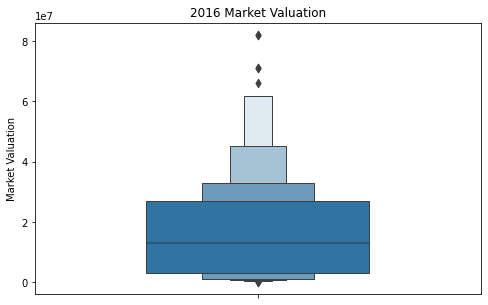

Text(17.200000000000003, 0.5, 'Market Valuation')

In [79]:
##Plot the Box graph for the "2016-Market Valuation"
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxenplot(y='Value', data=Players_Dataset_df_clean, width=0.5)
#sns.boxenplot(y='Value', data=Players_Dataset_df_clean, width=0.5)
ax.set_title('2016 Market Valuation')
#ax.set_xlabel('xlabel')
ax.set_ylabel('Market Valuation')
#ax.set_title('axes title')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')
plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
#ax = fig.add_subplot(111)
#ax.boxplot(data)

ax.set_title('2016 Market Valuation')
#ax.set_xlabel('xlabel')
ax.set_ylabel('Market Valuation')

/Users/anubhavpareek/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


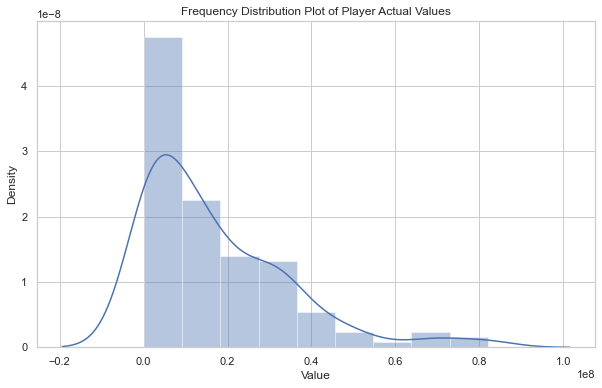

In [80]:
#Plot Frequency Distribution of Player 
x = Players_Dataset_df_clean.Value
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.distplot(x).set_title('Frequency Distribution Plot of Player Actual Values')
plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

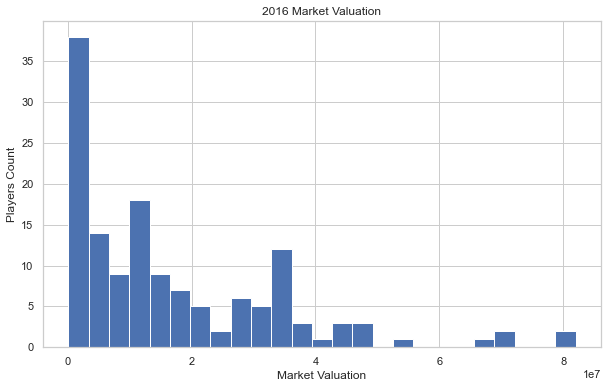

In [81]:
# Histogram plot of Player Values - 2016 Market Valuation
fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot(111)
sns.set(style="whitegrid")
ax.set_title('2016 Market Valuation')
ax.set_ylabel('Players Count')
ax.set_xlabel('Market Valuation')
plt.hist( x= 'Value', bins=25,data=Players_Dataset_df_clean)
#plt.title('Value distribution of all players')
plt.savefig('Hist.png', dpi=300, bbox_inches='tight')
plt.show()

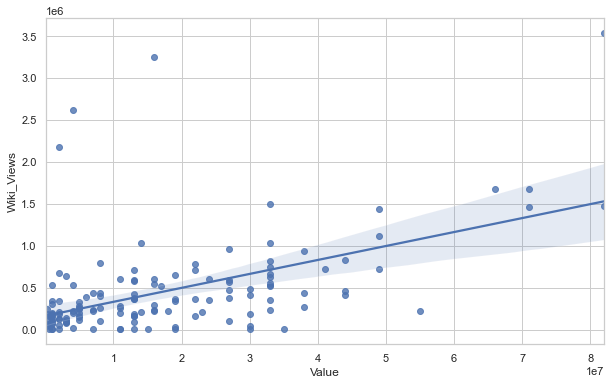

In [82]:
#Plot Wiki-views with Player Valuation - 2016 Player Valuations
plt.figure(figsize=(10,6))
sns.regplot(x="Value",y="Wiki_Views",data=Players_Dataset_df_clean)
plt.savefig('Wiki_Views.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 2000x2000 with 0 Axes>

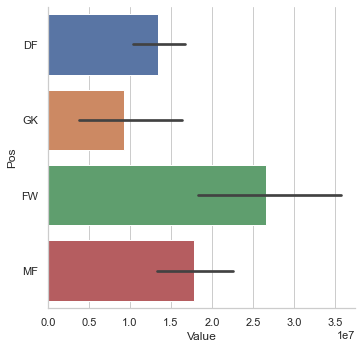

In [83]:
# Plot Position with respect to 2016 - Market Valuation
plt.figure(figsize=(10,10),dpi=200)
graph = sns.catplot(y="Pos", x="Value", kind="bar",  data=Players_Dataset_df_clean)
plt.savefig('Pos.png', dpi=300, bbox_inches='tight')
plt.show()

#### Modelling

In [84]:
#View the correlations of the features
corr_mat = Players_Dataset_df_clean.corr()
corr_mat;

In [85]:
#Correlation With Value (most correlated with positive)
pd.DataFrame(corr_mat["Value"]).sort_values("Value", ascending=False).head(10);

In [86]:
#Correlation With Value (modes correlated with negative)
pd.DataFrame(corr_mat["Value"]).sort_values("Value", ascending=True).head(7);

In [87]:
Players_Dataset_df_clean.head();

In [88]:
# Slice data into Features and Target values.

Players_Dataset_df_clean_model = Players_Dataset_df_clean.copy()

In [89]:
# Replace the infinity with NA and drop them later 
Players_Dataset_df_clean_model_2 = Players_Dataset_df_clean_model.replace([np.inf, -np.inf], np.nan)

In [90]:
Players_Dataset_df_clean_model_2.dropna();

In [91]:
# We fill for any missing values and we make sure that we have no nulls or NAs
Players_Dataset_df_clean_model_2 = Players_Dataset_df_clean_model_2.fillna(method='ffill')

In [92]:
Players_Dataset_df_clean_model_2.isnull().sum();

In [93]:
# Preparing the model to be used below for the OLS.
Xb= Players_Dataset_df_clean_model_2.drop(columns=["Player","Team","Nation","Pos","Footedness","Target"])
yb= Players_Dataset_df_clean_model_2.loc[:,"Target"]

In [94]:
Xb.head();

In [95]:
# fit model with target as player market value(2017)
player_modelb = sm.OLS(yb, Xb, data=Players_Dataset_df_clean_model_2)

resultsb = player_modelb.fit()

print(resultsb.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.823
Method:                 Least Squares   F-statistic:                              33.71
Date:                Mon, 25 Jan 2021   Prob (F-statistic):                    4.81e-40
Time:                        11:26:56   Log-Likelihood:                         -2528.6
No. Observations:                 141   AIC:                                      5097.
Df Residuals:                     121   BIC:                                      5156.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [96]:
X1= Players_Dataset_df_clean_model_2.loc[:,['MP','Age','Min','Gls','Ast','CrdY','CrdR','Height','Weight','Value','Wiki_Views']]
y1= Players_Dataset_df_clean_model_2.loc[:,"Target"]

In [97]:
#what coefficients our regression model has chosen
regressor = LinearRegression()
regressor.fit(X1,y1)
coeff_df = pd.DataFrame(regressor.coef_, X1.columns, columns=['Coefficient'])  
coeff_df.sort_values("Coefficient",ascending=False).T

,Gls,Ast,Height,Min,Wiki_Views,Value,Weight,MP,CrdY,Age,CrdR
Coefficient,1.203193e+06,268719.926215,75457.778689,8193.263895,6.336371,0.914784,-194143.061802,-374901.232956,-1.019174e+06,-1.973872e+06,-3.232947e+06


In [98]:

#Prediction on all data and calculate difference between tha actual value and predicted value
y_pred = regressor.predict(X1)
df = pd.DataFrame({'Name':Players_Dataset_df_clean_model_2.Player,'Actual': y1, 'Predicted': y_pred})
df["Difference"] = df["Actual"]-df["Predicted"]
df_under = round(df.sort_values('Difference').set_index('Name').head(10),2)
df_over = round(df.sort_values('Difference').set_index('Name').tail(10),2)
df_under

,Actual,Predicted,Difference
Name,,,
Jamie Vardy,275000.0,4.446284e+07,-44187840.73
Oumar Niasse,7000000.0,5.057777e+07,-43577768.17
Theo Walcott,55000.0,3.918385e+07,-39128854.88
Islam Slimani,550000.0,3.917097e+07,-38620968.84
Alexis Sánchez,77000000.0,1.114058e+08,-34405845.48
Wilfried Zaha,55000.0,2.739341e+07,-27338411.65
Wilfred Ndidi,2000000.0,2.735609e+07,-25356090.35
Christian Benteke,3000000.0,2.711862e+07,-24118615.45
Oriol Romeu,2000000.0,2.444639e+07,-22446394.60


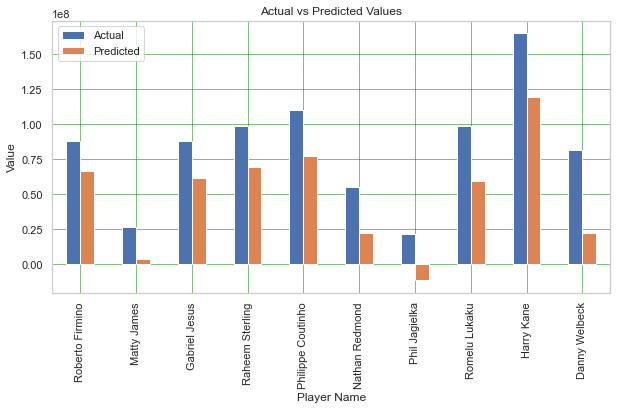

In [99]:
#Plot the comparision of Actual and Predicted Values for Under Predicted
df_over[["Actual","Predicted"]].plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Actual vs Predicted Values")
plt.xlabel("Player Name")
plt.ylabel('Value')
plt.savefig('AVP.png', dpi=300, bbox_inches='tight')
plt.show()

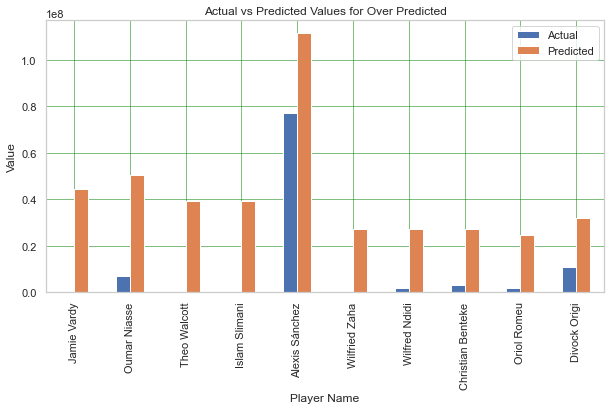

In [100]:
#Plot the comparision of Actual and Predicted Values for Over Predicted

df_under[["Actual","Predicted"]].plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Actual vs Predicted Values for Over Predicted")
plt.xlabel("Player Name")
plt.ylabel('Value')
plt.show()

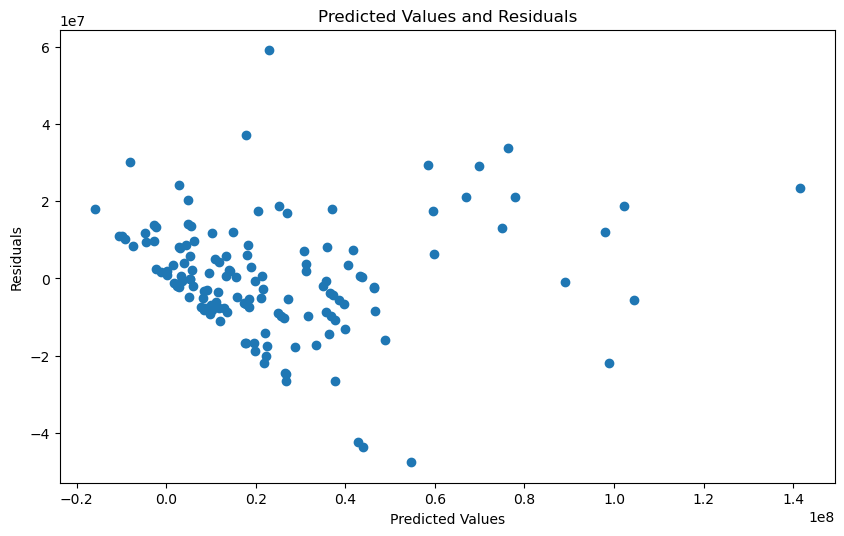

In [101]:
#Plotting Residuals
plt.figure(figsize=(10,6),dpi=100),
plt.style.use('default')
plt.scatter(resultsb.predict(), resultsb.resid);
plt.title("Predicted Values and Residuals")
plt.ylabel("Residuals")
plt.xlabel("Predicted Values")
plt.show()

In [102]:
Players_Dataset_df_clean_model_2_features = Players_Dataset_df_clean_model_2.drop(columns=["Target"])

In [103]:
Players_Dataset_df_clean_model_2_features.columns # Few features are redundant but for now lets keep them all 

Index(['Player', 'Team', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'PK', 'PKatt', 'CrdY', 'CrdR', 'PGls', 'PAst', 'PG+A',
       'PG-PK', 'PG+A-PK', 'Height', 'Weight', 'Footedness', 'Value',
       'Wiki_Views'],
      dtype='object')

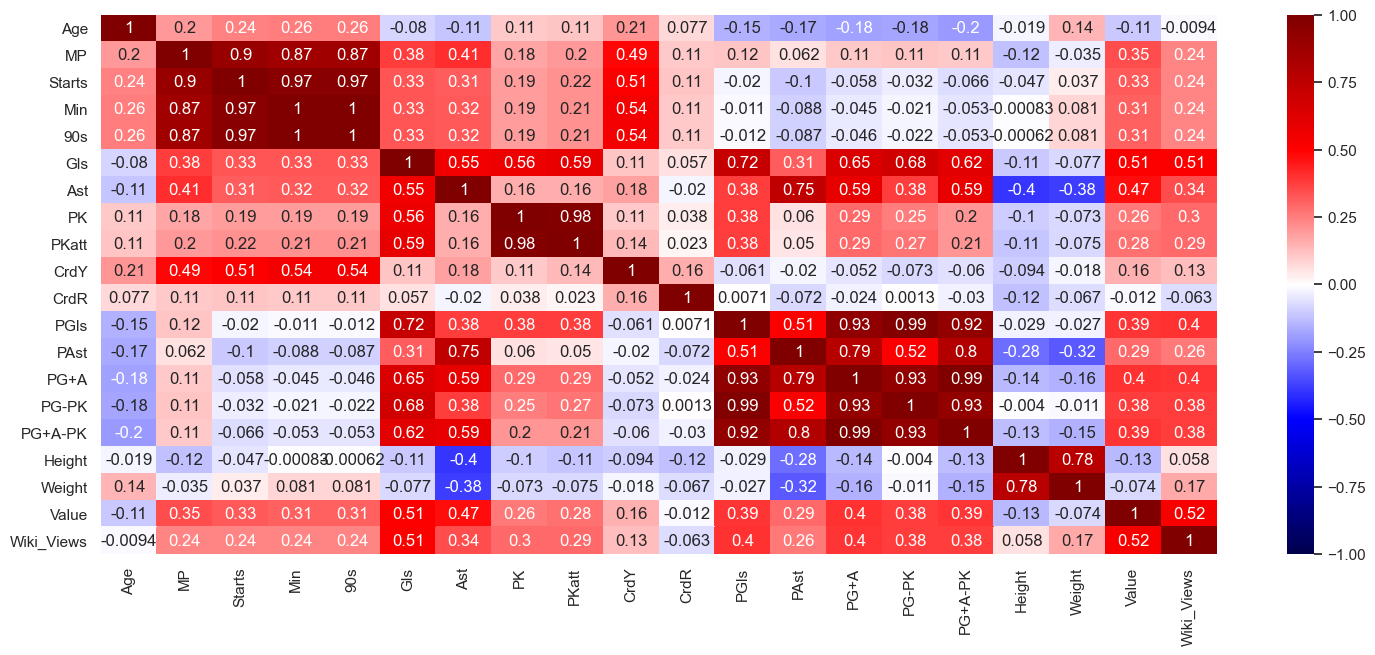

In [104]:
#Heatmap of correlated values- for all the features (a lot of feature are redundant)
plt.figure(1, figsize=(18, 7))
sns.set(style="whitegrid")
sns.heatmap(Players_Dataset_df_clean_model_2_features.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.yticks(rotation=0); 
plt.show()

<Figure size 1800x700 with 0 Axes>

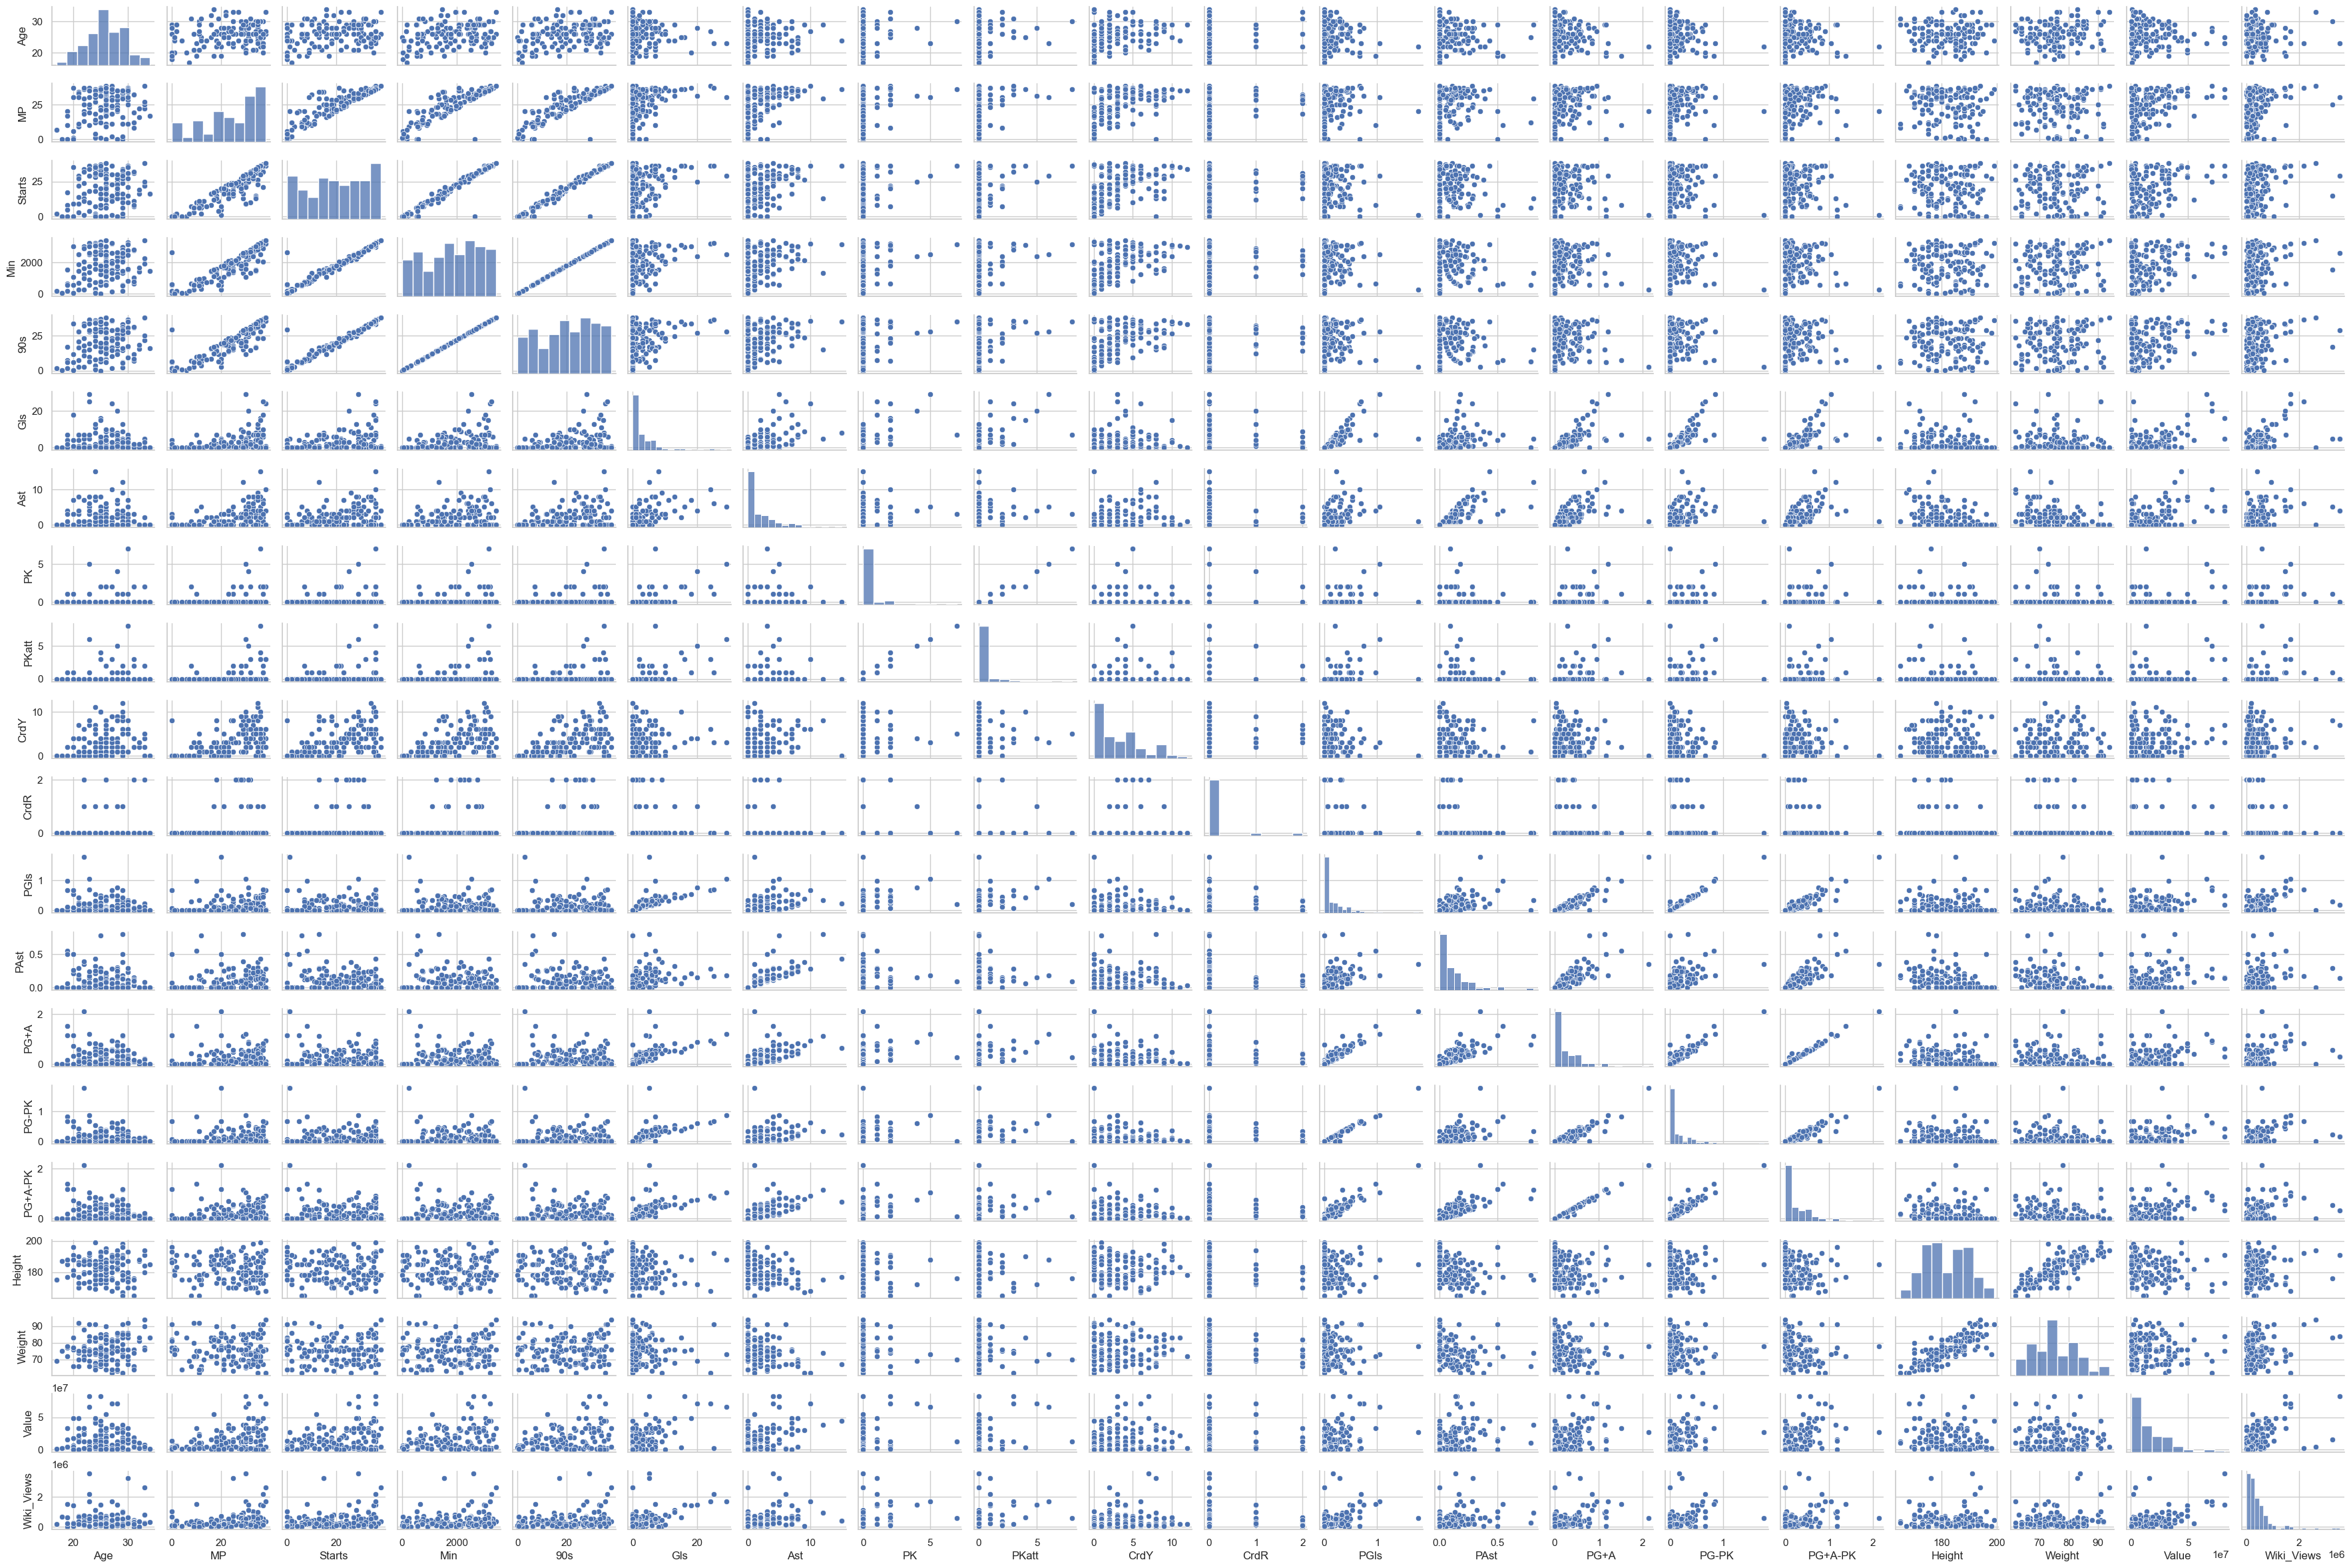

In [105]:
#Plot the Pair Plots
plt.figure(1, figsize=(18, 7))
sns.set(style="whitegrid")
g=sns.pairplot(Players_Dataset_df_clean_model_2_features, height=1.2, aspect=1.5)
plt.yticks(rotation=90)
plt.show()

In [106]:
#Prepare Model-1 with the features that we need 
X1= Players_Dataset_df_clean_model_2.loc[:,['MP','Age','Min','Gls','Ast','CrdY','CrdR','Height','Weight','Value','Wiki_Views']]
y1= Players_Dataset_df_clean_model_2.loc[:,"Target"]

<Figure size 1800x700 with 0 Axes>

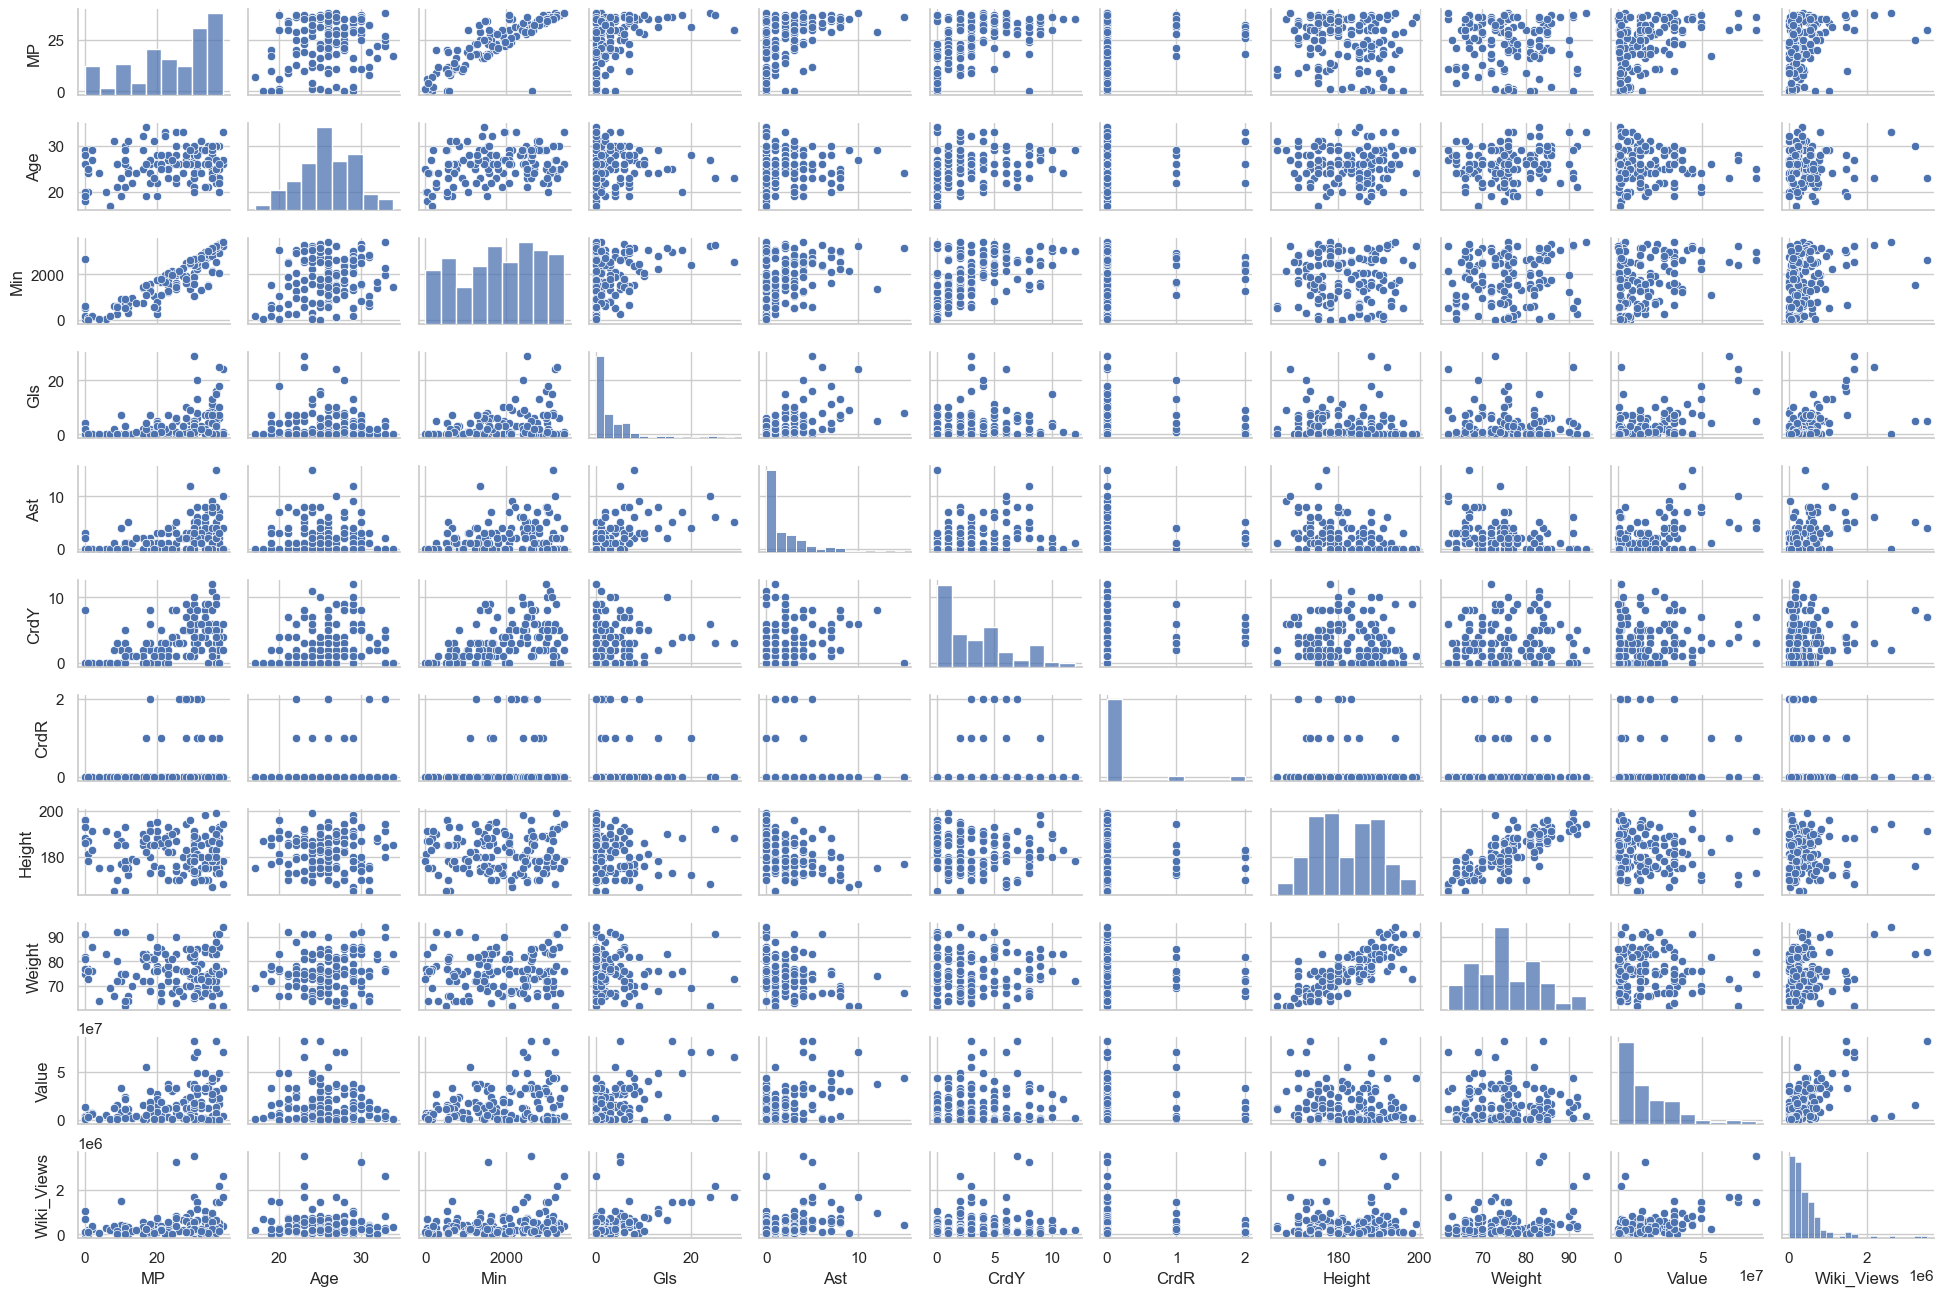

In [107]:
#Plot the pair plot for the selected features.
plt.figure(1, figsize=(18, 7))
sns.set(style="whitegrid")
g=sns.pairplot(X1, height=1.2, aspect=1.5)
plt.yticks(rotation=90); 
plt.savefig('PP.png', dpi=300, bbox_inches='tight')
plt.show()

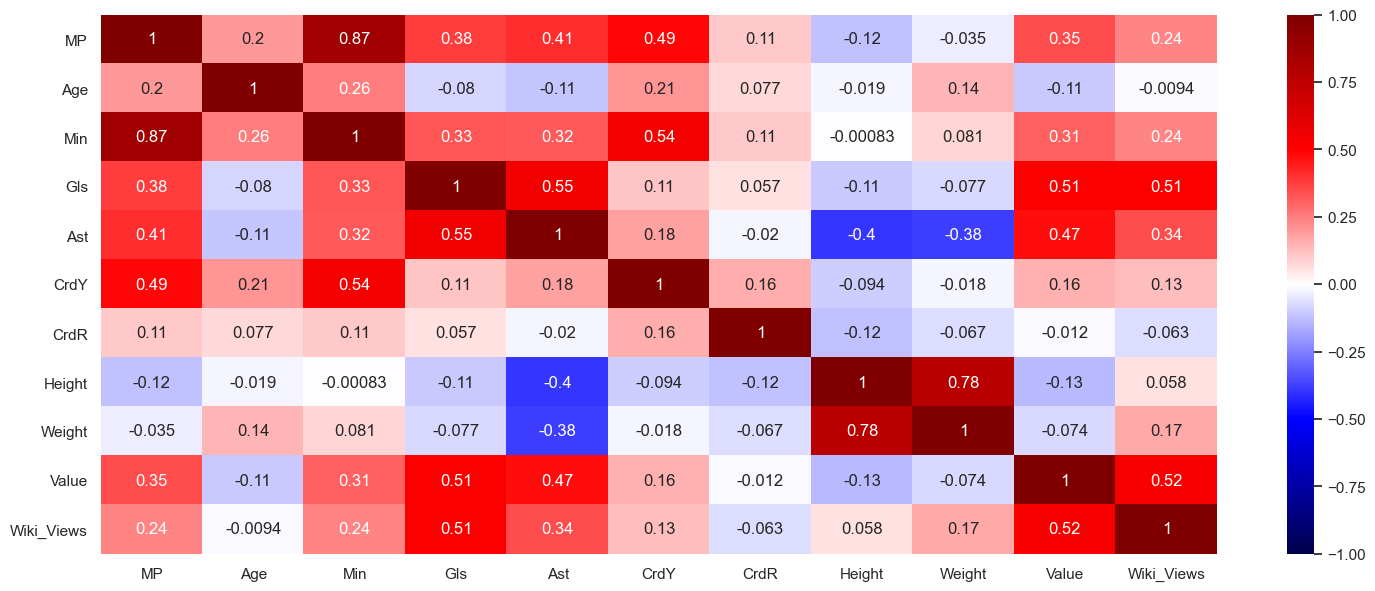

In [108]:
#Heatmap of correlated values- for selected features
plt.figure(1, figsize=(18, 7))
sns.set(style="whitegrid")
sns.heatmap(X1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.yticks(rotation=0); 
plt.savefig('Corr.png', dpi=300, bbox_inches='tight')
plt.show()

In [109]:
# Model1 - Linear Regression
#Split data into train, test and validation (%60 - %20 - 2-%)

X_train, X_test, y_train, y_test = train_test_split(X1,y1,test_size=0.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X1,y1, test_size=.25, random_state=10)

lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_val)
mse = np.mean((pred-y_val)**2)

print(lr.score(X_test,y_test)) # Get the R^2
print(mse) # Get the Mean Square Error 
print(lr.coef_) # Get the features

0.7998893987800881
383329419624141.25
[-7.48011666e+05 -2.16098937e+06  1.28846261e+04  1.03842459e+06
  8.78963415e+05 -1.15332695e+06 -3.99831834e+06 -2.98392860e+05
  1.68009978e+05  8.74283595e-01  6.62279823e+00]


In [110]:
coeff = pd.DataFrame(X_train.columns)

coeff['CoefficientEstimate'] = lr.coef_

coeff.sort_values("CoefficientEstimate")

,0,CoefficientEstimate
6,CrdR,-3.998318e+06
1,Age,-2.160989e+06
5,CrdY,-1.153327e+06
0,MP,-7.480117e+05
7,Height,-2.983929e+05
9,Value,8.742836e-01
10,Wiki_Views,6.622798e+00
2,Min,1.288463e+04
8,Weight,1.680100e+05
4,Ast,8.789634e+05


In [115]:
#set up the 4 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values) # Scale Training data 
X_val_scaled = scaler.transform(X_val.values) # Scale validation data
X_test_scaled = scaler.transform(X_test.values)# Scale Test data 

lm_reg = Ridge(alpha=0.05, normalize=True) # Ridge optimization 

lm_lasso = Lasso(alpha=0.05, normalize=True)# LASSO optimization

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) #Polynomial model

X1_poly = poly.fit_transform(X1.values)
X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

lm.fit(X_train, y_train)
print(f'Linear Regression for all data R^2: {lm.score(X1, y1):.3f}')
print(f'Linear Regression for validation data R^2: {lm.score(X_val, y_val):.3f}')
print(f'Linear Regression for test data R^2: {lm.score(X_test, y_test):.3f}')
print("")

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression for validation data R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression for test data R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')
print("")


lm_lasso.fit(X_train,y_train)
print(f'Lasso Regression for validation data R^2: {lm_lasso.score(X_val, y_val):.6f}')
print(f'Lasso Regression for test data R^2: {lm_lasso.score(X_test, y_test):.6f}')
print("")

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression for validayion data R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression for test data R^2: {lm_poly.score(X_test_poly, y_test):.3f}')


Linear Regression for all data R^2: 0.711
Linear Regression for validation data R^2: 0.679
Linear Regression for test data R^2: 0.800

Ridge Regression for validation data R^2: 0.700
Ridge Regression for test data R^2: 0.823

Lasso Regression for validation data R^2: 0.679392
Lasso Regression for test data R^2: 0.799889

Degree 2 polynomial regression for validayion data R^2: -4.034
Degree 2 polynomial regression for test data R^2: -3.993


In [112]:
model= sm.OLS(y1, X1, data=Players_Dataset_df_clean_model_2)

results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Target   R-squared (uncentered):                   0.829
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                              57.47
Date:                Mon, 25 Jan 2021   Prob (F-statistic):                    1.71e-44
Time:                        11:27:57   Log-Likelihood:                         -2536.7
No. Observations:                 141   AIC:                                      5095.
Df Residuals:                     130   BIC:                                      5128.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [113]:
# Dummy Variables for Position

X3 = pd.concat([Players_Dataset_df_clean_model_2_features.drop('Pos', axis=1), pd.get_dummies(Players_Dataset_df_clean_model_2['Pos'])],axis=1)

X3 = X3.drop(columns=["Team","Player","Footedness","Wiki_Views","Nation"])

y3 = yb= Players_Dataset_df_clean_model_2.loc[:,"Target"]

In [114]:
# fit model with target as player market value 
player_model3 = sm.OLS(y3, X3, data=Players_Dataset_df_clean_model_2)

results3 = player_model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     16.50
Date:                Mon, 25 Jan 2021   Prob (F-statistic):           2.12e-26
Time:                        11:27:57   Log-Likelihood:                -2526.8
No. Observations:                 141   AIC:                             5100.
Df Residuals:                     118   BIC:                             5167.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age        -2.028e+06   4.54e+05     -4.463      0.0

In [122]:
#Run Cross Validation - 10 splits - for our regression model

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
kf = KFold(n_splits=10, shuffle=True, random_state = 100)

print(round(np.mean(cross_val_score(lm, X_val, y_val, cv=kf, scoring='r2')),3))

-0.316


## Linear Regression Assumptions


#### Assumption 1: regression is linear in parameters and correctly specified¶


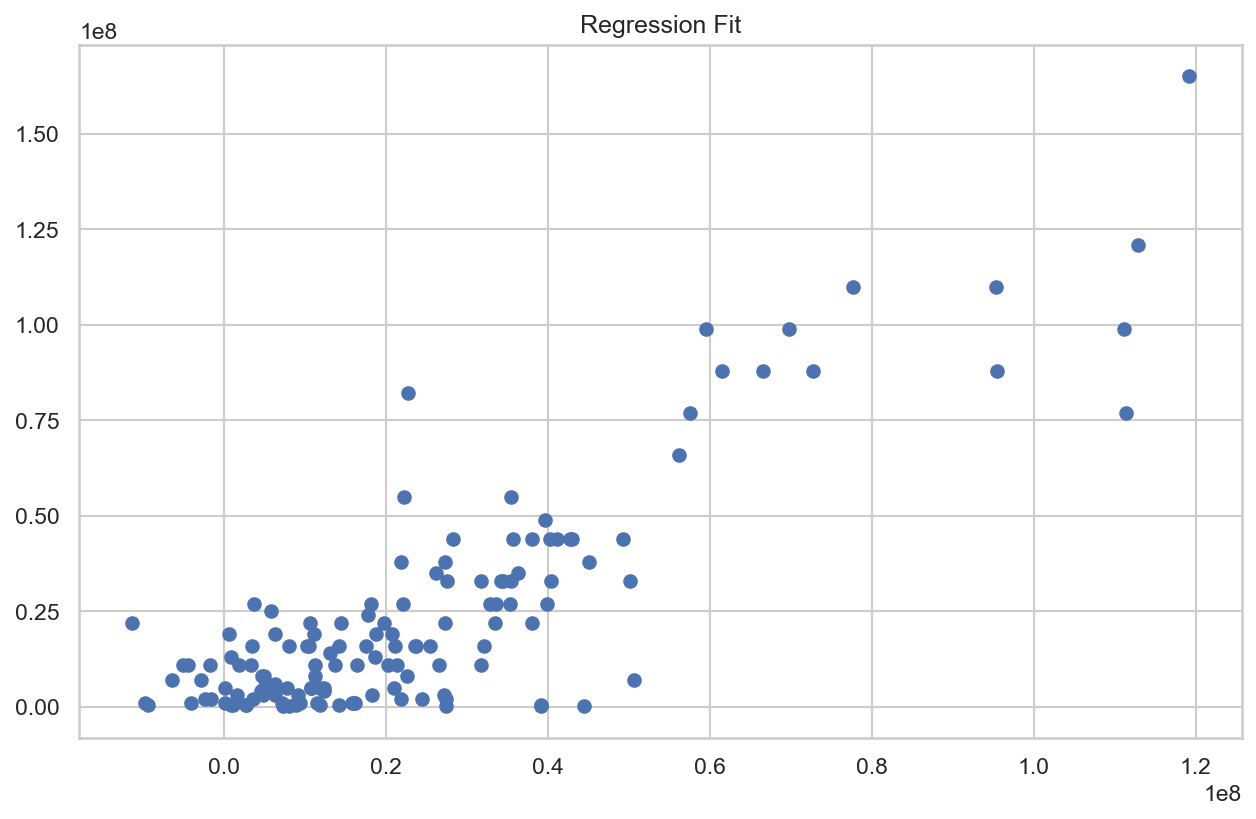

In [123]:
# Regression Fit
plt.figure(figsize=(10,6),dpi=150),
lr = LinearRegression()
fit = lr.fit(X1,y1);
pred = lr.predict(X1)
plt.scatter(pred,y1)
plt.title("Regression Fit")
plt.show()


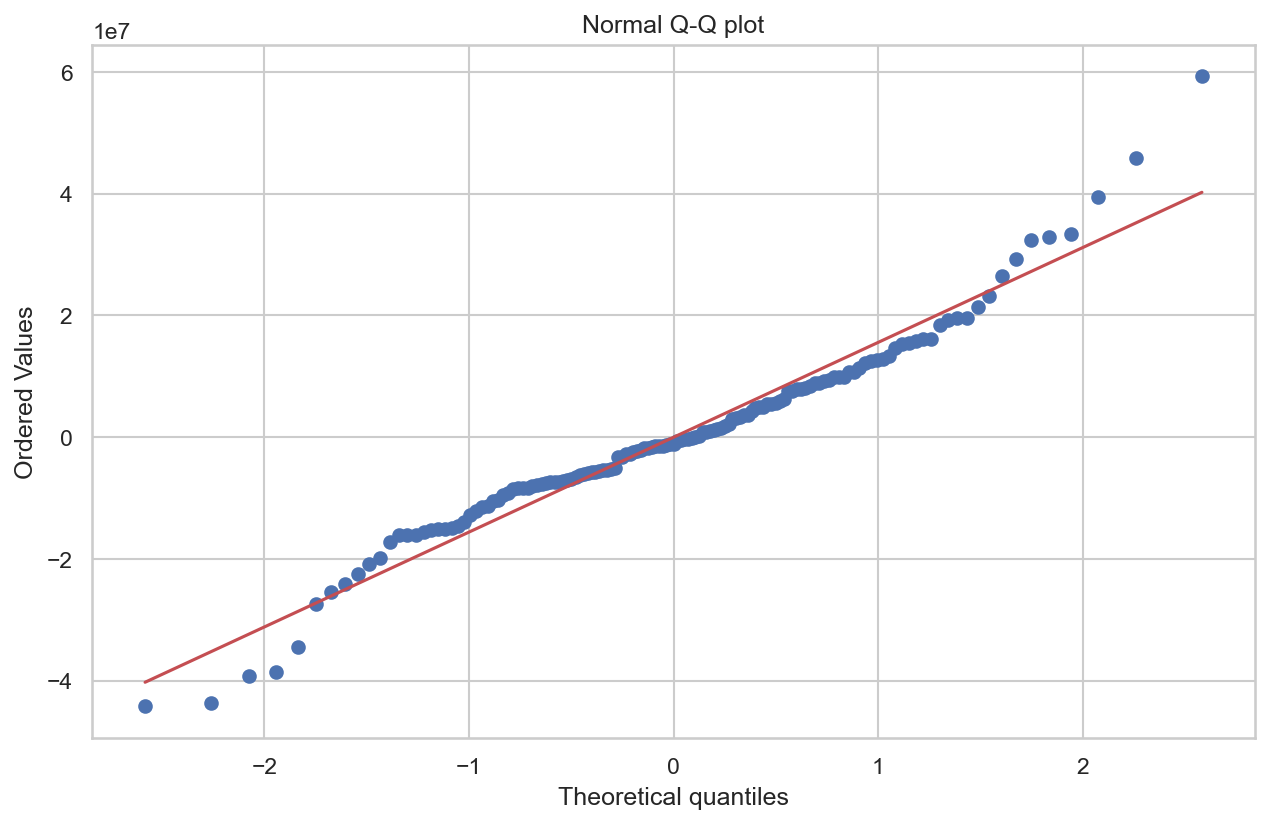

In [124]:
# Normal Q-Q Plot
df['predict']=(regressor.predict(X1))
df['resid']= (y1-df.predict)
plt.figure(figsize=(10,6),dpi=150),
stats.probplot(df['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

#### Assumption 2: residuals should be normally distributed with zero mean


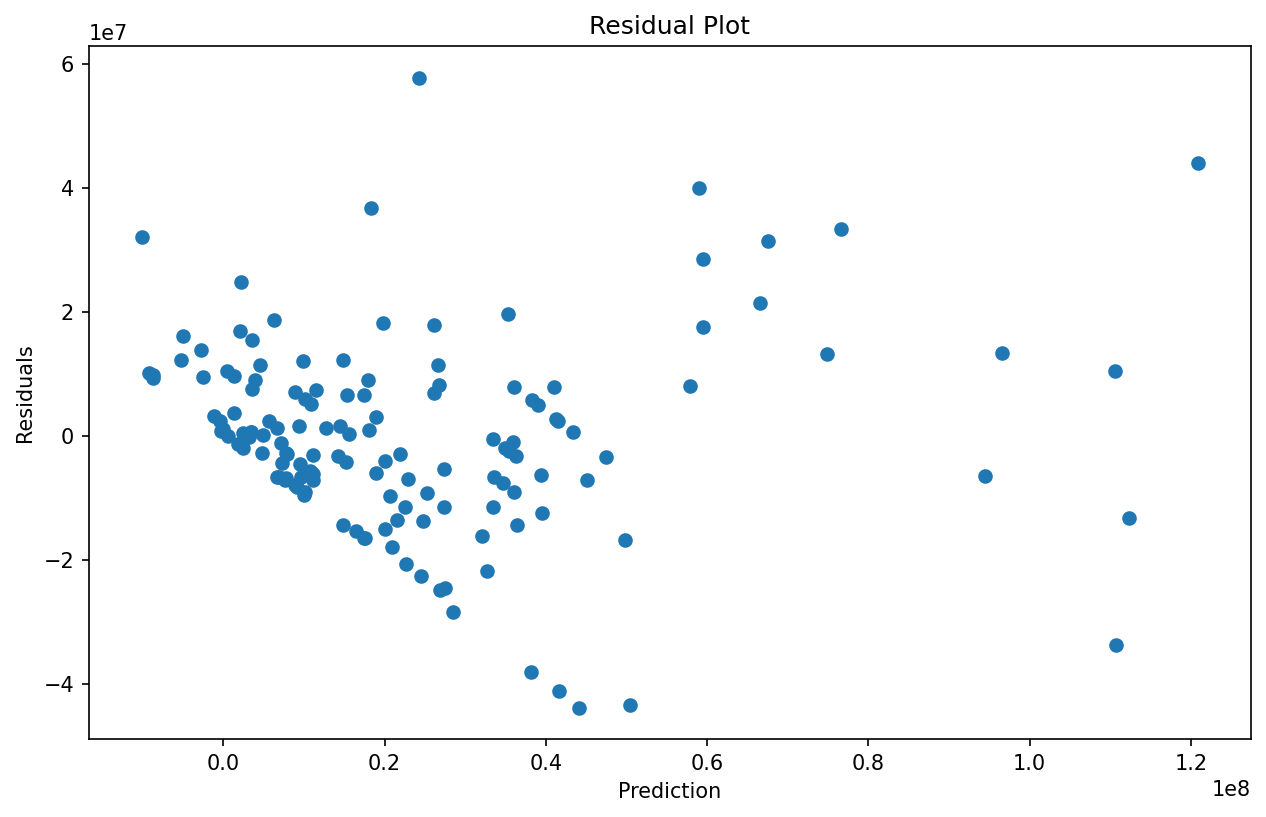

In [125]:

# Plot your predicted values on the x-axis, and your residuals on the y-axis

player_model = sm.OLS(y1, X1, data=Players_Dataset_df_clean_model_2)

resultsl = player_model.fit()

plt.figure(figsize=(10,6),dpi=150),
plt.style.use('default')
plt.scatter(resultsl.predict(), resultsl.resid);
plt.title("Residual Plot")
plt.ylabel("Residuals")
plt.xlabel("Prediction")
plt.show()


#### Assumption 3: Homoscedasticity test for residuals


2

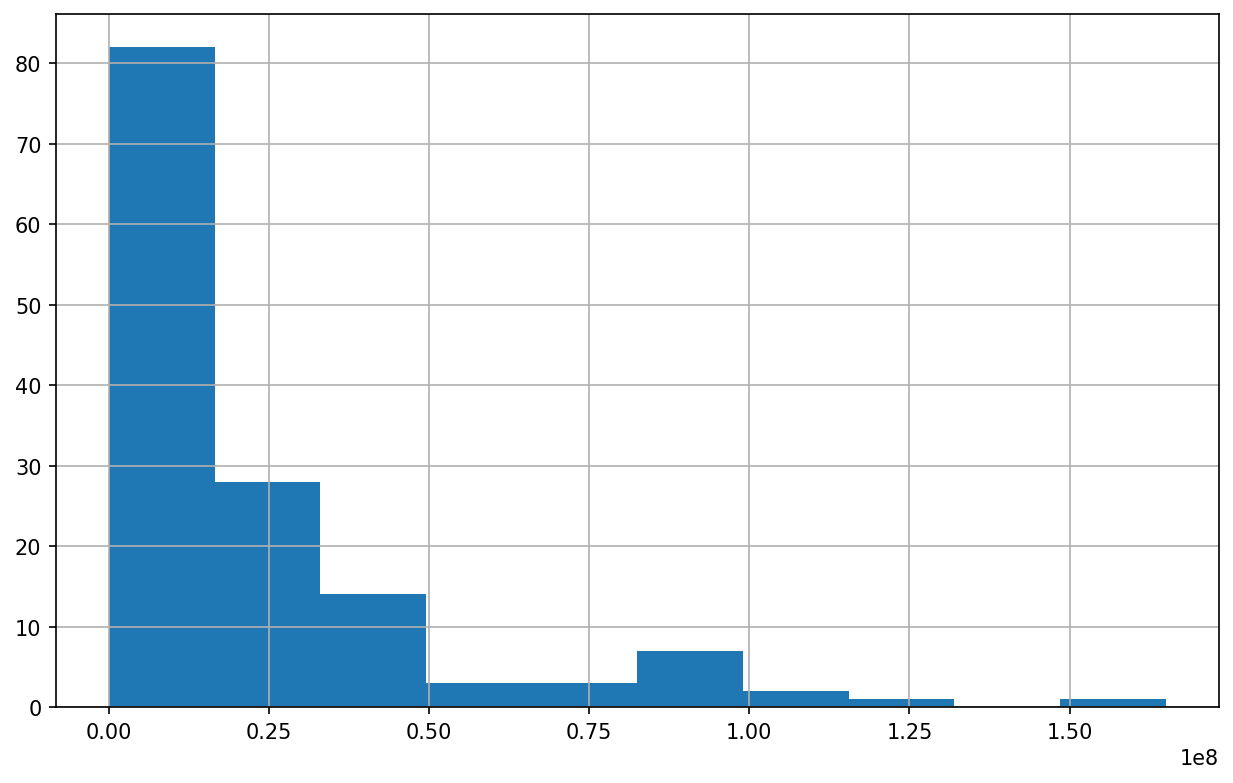

In [126]:
# create histogram
plt.figure(figsize=(10,6),dpi=150),

y1.hist();
2
# note the positive skew

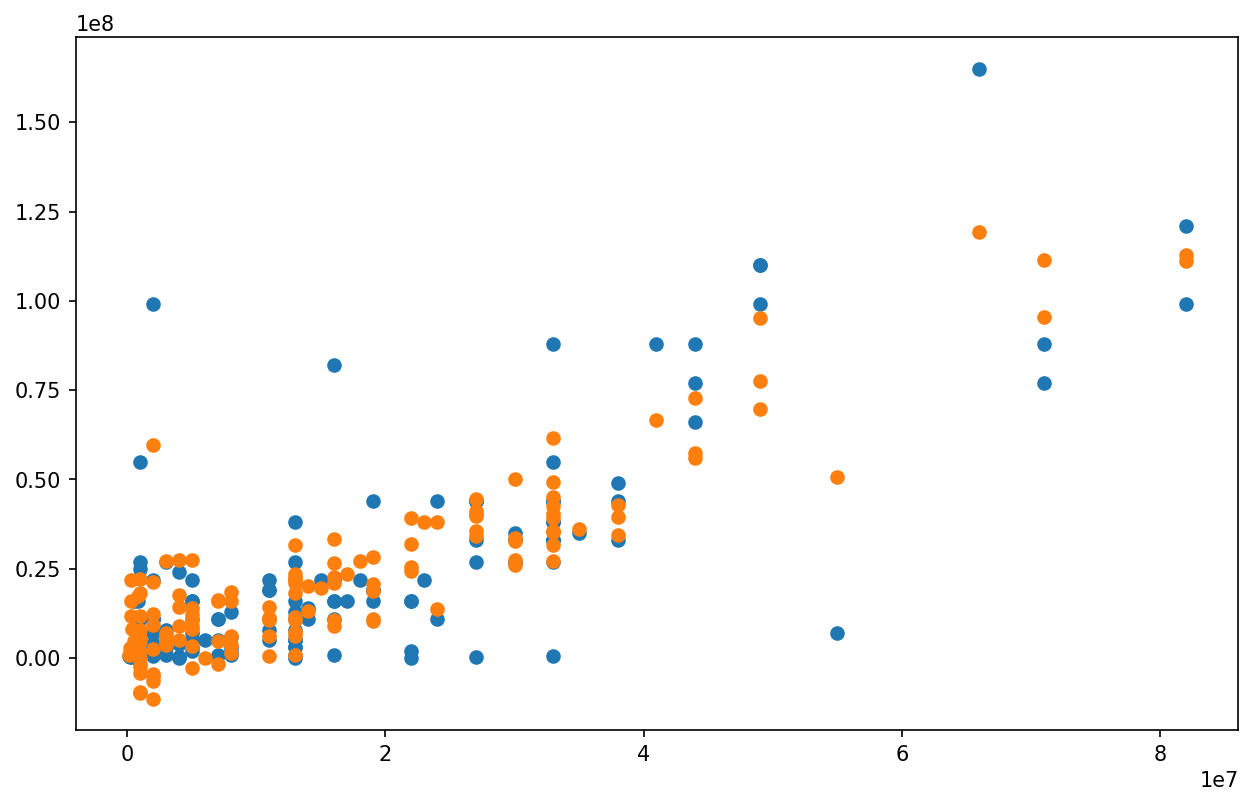

In [127]:
# quick reg plot
plt.figure(figsize=(10,6),dpi=150),


plt.scatter(X1.Value,y1)
plt.scatter(X1.Value,df.predict);

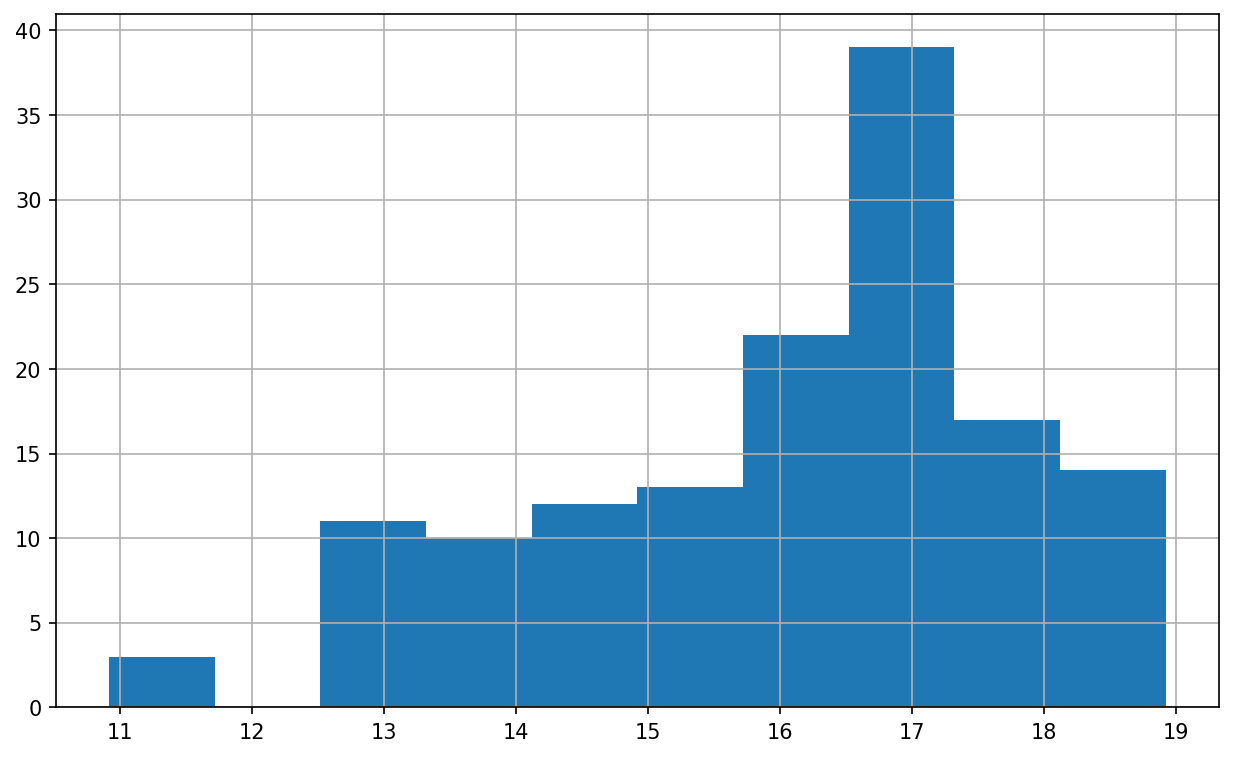

In [128]:
plt.figure(figsize=(10,6),dpi=150),
np.log(y1).hist();

#### Assumption 4: Detecting correlation between residuals and observations


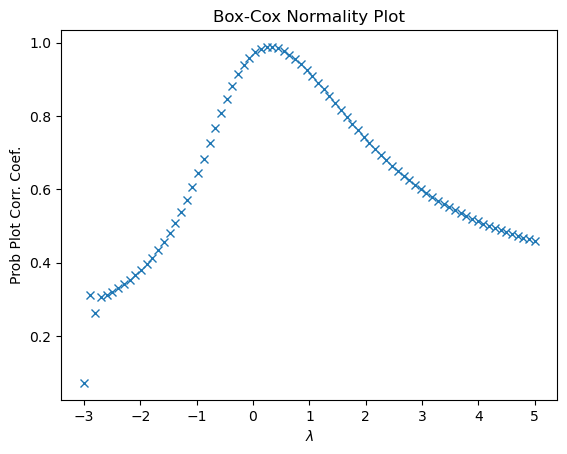

In [129]:
# plot to show optimal lambda values
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(Players_Dataset_df_clean_model_2.Value, -3, 5, plot=ax)